In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym
from gymnasium.spaces import Dict, Box, Discrete

import optuna

import os
import time
import pickle
import sys
sys.path.append('../src/')
from neural_nets import DQN, exponential_schedule, linear_schedule
from buffer import ReplayBuffer
from scipy.spatial.distance import cdist

import wandb

import torch
import torch.nn as nn
from torch.nn import functional as F

from collections import namedtuple, deque


In [2]:
def get_distance_matrix(X,Y):
  """"""
  return cdist(X,Y,metric='euclidean')

In [3]:
def get_distance(point1,point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = False

# Setup experiment

In [5]:
env_name = 'ToyEnv_v1'

OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
    
SEED = 10
seed_everything(SEED)

torch.set_default_dtype(torch.float32)

## Configure logger

In [6]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'DQN_closest_distance_path.ipynb'
run = wandb.init(project=f"DQN-{env_name}", dir=OUTDIR)

wandb: Currently logged in as: rhur (rhur-uc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Simulate train dataset

In [7]:
def get_target_sequence(coords, distance_matrix):
    """
    Given a list of coordinates, picks the field closest to the origin first, then 
    always picks the field closest unless it has already been visited
    """
    ordered_indices = np.argsort(distance_matrix, axis=1) # low to high

    start_ind = np.argmin(np.sum(coords**2, axis=1))
    target_indices = [start_ind]

    last_ind = start_ind
    for i in range(len(coords) - 1):
        j = 0
        current_ind = ordered_indices[last_ind][j]
        while current_ind in target_indices:
            j += 1
            current_ind = ordered_indices[last_ind][j]
        target_indices.append(current_ind)
        last_ind = current_ind
    return target_indices, coords[target_indices]

In [8]:
def generate_dataset(num_episodes=100):
    grid_max = 10
    ra_range = (-grid_max, grid_max)
    dec_range = (-grid_max, grid_max)
    n_points = grid_max
    nvisits = 1
    
    # generate random coords
    ra_list = np.random.randint(ra_range[0], ra_range[1], size=(num_episodes, n_points))
    dec_list = np.random.randint(dec_range[0], dec_range[1], size=(num_episodes, n_points))
    coords = np.stack([ra_list, dec_list], axis=2) # shape (num_ep, nra_points, ndec_points)
    coords_dict = {f'eps{i}': coord for i, coord in enumerate(coords)}
    
    distance_matrices = np.empty(shape=(num_episodes, grid_max, grid_max))
    full_target_fields = []
    full_target_coords = []
    # get distance matrices
    for i in range(num_episodes):
        distance_matrices[i] = get_distance_matrix(coords[i], coords[i])
        np.fill_diagonal(distance_matrices[i], np.inf)
        target_fields, target_coords = get_target_sequence(coords[i], distance_matrices[i])
        full_target_fields.append(target_fields)
        full_target_coords.append(target_coords)
        # full_target_coords.append(coords[i][target_fields])
    return np.array(full_target_fields), np.array(full_target_coords), coords_dict, coords

    

In [9]:
target_fields, target_coords, coords_dict, coords = generate_dataset(100)

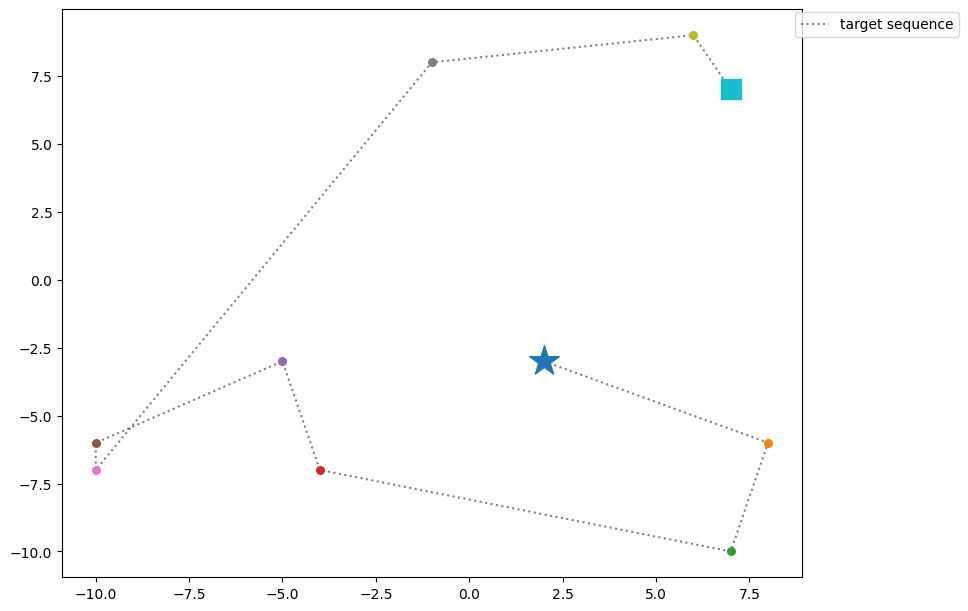

In [10]:
j = 10

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(target_coords[j][:, 0], target_coords[j][:, 1], linestyle='dotted', label='target sequence', zorder=1, color='grey')

for i, index in enumerate(target_fields[j]):
    if i == 0:
        marker = '*'
        s = 500
    elif i == len(target_fields[j])-1:
        marker = 's'
        s = 200
    else:
        marker = 'o'
        s = 30
    ax.scatter(coords[j][index][0], coords[j][index][1], marker=marker, s=s)
fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
# fig.legend

## Set up environment

In [ ]:
class ToyEnv_v1(gym.Env):
    def __init__(self, coords_dict, max_visits, target_fields):
        # instantiate static attributes
        self.coords_dict = coords_dict # field_id: (x,y)
        # self.nfields = len(coords_dict) #TODO change for closest distance reward fxn
        self.max_visits = max_visits
        self.zenith = np.array([0,0])
        self.target_sequence = target_fields

        # Initialize variable attributes - will be set in reset()
        self._init_to_nonstate()
       
        # Define observation space
        self.obs_size = 2 + self.nfields * self.max_visits
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1e5,
            shape=(self.obs_size,),
            dtype=np.float32,
        )
        # self.observation_space = gym.spaces.Dict(
        #     {
        #         "field_id": Discrete(n=self.nfields, start=-1),
        #         "nvisits": Box(0, max_visits, shape=(self.nfields,), dtype=np.int32),
        #         "step_count": Discrete(n=self.nfields, start=-1),
                # "ra": Box(ra_range[0], ra_range[1], shape=(self.nfields), dtype=np.float32),
                # "dec": Box(dec_range[0], dec_range[1], shape=(self.nfields), dtype=np.float32),
            # }
        # )

        # Define action space        
        self.action_space = gym.spaces.Discrete(self.nfields)

    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        # return {
        #     "field_id": self._field_id,
        #     "nvisits": self._nvisits,
        #     "step_count": self._step_count
        # }
        obs = np.concatenate([np.array([self._step_count]), np.array([self._field_id]), self._nvisits])
        return obs.astype(np.float32)

    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'action_mask': self._action_mask}
    
    def _update_action_mask(self):
        """Update mask for cutting invalid actions.
        Must update self._field and self._nvisits before updating actions
        """
        # prev_action_mask = self._action_mask.copy()
        if self._nvisits[self._field_id] == self.max_visits:
            new_mask = self._action_mask.copy()
            new_mask[self._field_id] = False
            self._action_mask = new_mask

    def _update_obs(self):
        self._step_count += 1
        self._nvisits[self._field_id] += 1
        self._visited.append(self._field_id)
        self._coord = self.coords_dict[self._field_id] #TODO need to change for closest distance learning
        self._update_action_mask()

    def _init_to_nonstate(self):
        self._field_id = -1
        self._nvisits = np.full(shape=(self.nfields,), fill_value=0, dtype=np.int32)
        self._step_count = -1
        self._visited = []
        self._coord = np.array([None, None])
        self._action_mask = np.ones(self.nfields, dtype=bool)

    def reset(self, seed = None, options=None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize into a non-state.
        # this allows first field choice to be learned
        self._init_to_nonstate()
        observation = self._get_obs()
        info = self._get_info()
        return observation, info
    
    def step(self, action: int):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        self._field_id = action
        self._update_obs()
        # if self._step_count == 0:
        #     last_field_coord = self.zenith
        # else:
        #     last_field_coord = self.coords_dict[self._visited[-2]]

        # separation = get_distance(self._coord, last_field_coord)
        # if separation <= self.nfields//5*2:
        #     reward = 1
        # elif separation <= self.nfields//5*3:
        #     reward = .5
        # elif separation <= self.nfields//5*4:
        #     reward = .1
        # else:
        #     reward = 0

        off_by_val = np.abs(self.target_sequence[self._step_count] - self._field_id) ==  3
        if self.target_sequence[self._step_count] == self._field_id:
            reward = 1
        elif off_by_val:
            print()
            reward = .25
        else:
            reward = 0    
        total_visits = int(self.nfields * self.max_visits)
        
        all_objects_visited = total_visits == self._step_count + 1

        # end condition
        terminated = all_objects_visited
        truncated = False

        # get obs and info
        next_obs = self._get_obs()
        info = self._get_info()

        return next_obs, reward, terminated, truncated, info

## 

In [12]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v1,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)
env = gym.make(f"gymnasium_env/{env_name}", coords_dict=coords_dict['eps0'], max_visits=1, target_fields=target_fields[0])
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


## Pytorch Agent and DQN implementation

In [13]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

In [14]:
# wandb.log({}, step=2)

In [15]:
from typing import Tuple

class DQNAgent:
    def __init__(
            self,
            env: gym.Env, 
            replay_buffer: ReplayBuffer, 
            # net: nn.Module,
            device,
            ):
        """Base Agent class handling the interaction with the environment.
        """
        self.env = env
        self.replay_buffer = replay_buffer
        n_observations = len(self.env.reset()[0])
        n_actions = self.env.action_space.n
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.training_phase = True

        self.reset()
        self.steps_done = 0
        self.device = device
        self.start_time = time.time()


    def reset(self) -> None:
        """Resets the environment and updates the state."""
        self.obs, self.info = self.env.reset()

    def select_action(self, epsilon: float) -> int:
        """Using the given network, decide what action to carry out using an epsilon-greedy policy.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action

        """
        # if random sample less than epsilon, take random action
        if self.training_phase and np.random.random() < epsilon:
            valid_actions = np.where(self.info['action_mask'])[0]
            action = self.env.np_random.choice(valid_actions)
            return action

        # get action given obs using policy
        obs = torch.tensor(self.obs)
        if self.device == torch.device('cuda'):
            obs = obs.cuda(self.device)

        with torch.no_grad():
            obs_tensor = obs.unsqueeze(0)
            q_values = self.policy_net(obs_tensor).squeeze(0)

            # Apply mask: set invalid actions to -inf
            masked_q_values = q_values.clone()
            masked_q_values[torch.tensor(~self.info['action_mask'])] = float('-inf')
            action = torch.argmax(masked_q_values).item()
            # action = int(action.item())
        return action

    @torch.no_grad()
    def play_step(
        self,
        epsilon: float = 0.0,
    ) -> Tuple[float, bool]:
        """Carries out a single interaction step between dthe agent and the environment.

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action

        Returns:
            reward, done

        """
        action_mask = self.info['action_mask']
        # select action
        action = self.select_action(epsilon)

        # interact with environment
        next_obs, reward, terminated, truncated, info = self.env.step(action)
        next_action_mask = info['action_mask']

        # save to experiences
        exp_args = self.obs, action, reward, next_obs, terminated, action_mask, next_action_mask
        self.replay_buffer.append(*exp_args)

        # set next_obs to current obs for next step
        self.obs = next_obs
        self.info = info

        # if finished survey, reset
        if terminated or truncated:
            self.reset()
        return reward, terminated
    
    def predict(self, nsteps):
        obs = []
        for t_i in nsteps:
            reward, terminated = self.play_step()
            

In [20]:
from collections.abc import Callable

def train_agent(
        agent: DQNAgent,
        total_timesteps: int,
        # num_episodes, # or total timesteps?
        lr: float,
        batch_size: int,
        gamma: float,
        eps_scheduler_kwargs: dict[str, int | str],
        tau: float,
        # device: torch.device, # take from agent
        eps_scheduler: Callable,
        optimizer: torch.optim.Optimizer,
        optimizer_kwargs: Dict,
        learn_start: int,
        train_freq: int, #4
        target_freq: int,
        ):
    """
    Trains a DQN agent.
    
    Args
    -----
    agent: DQNAgent
    total_timesteps: int
        Total number of timesteps through which to step agent through environment.
        Number of episodes is total_timesteps // episode_steps
    lr: float
    batch_size: int
    gamma: float
    eps_scheduler_kwargs: dict[str, int | str]
        arguments for epsilon scheduling method
    tau: float
    eps_scheduler: Callable,
        Function that calculates epsilon at each time step
    optimizer: torch.optim.Optimizer,
        Optimizer for neural network. Adamw is recommended.
    optimizer_kwargs: Dict,
        Kwargs for chosen optimizer
    learn_start: int
        Time step at which updates to policy network and target network 
    train_freq: int, #4
        Number of time steps between policy network updates  
    target_freq: int
        Number of time steps between target network updates

    Returns
    -------
    None
    """
    start_time = time.time()
    wandb.log({'train_start_time': start_time})
    obs, info = agent.env.reset()
    optimizer = optimizer(agent.policy_net.parameters(), lr=lr, amsgrad=False, **optimizer_kwargs)

    for t_i in range(total_timesteps):
        # set epsilon according to scheduler
        epsilon = eps_scheduler(t=t_i, **eps_scheduler_kwargs)

        # agent performs step in environment and sees next observation
        _, _ = agent.play_step(epsilon)
        
        # use temporal difference between new obs and last obs to update Q-values
        if t_i > learn_start and t_i % train_freq == 0 and batch_size < len(agent.replay_buffer):
            # sample from experiences
            obs, actions, rewards, next_obs, dones, _, next_action_masks = agent.replay_buffer.sample(batch_size)
            current_q = agent.policy_net(torch.tensor(obs)).gather(1, torch.tensor(actions).unsqueeze(1)).squeeze()
            with torch.no_grad():
            # gets maximally valued action for each observation in batch
                # next_q = agent.target_net(torch.tensor(next_obs, device='cpu'))
                next_q = agent.target_net(torch.tensor(np.array(next_obs), device='cpu'))

                # mask invalid actions
                for i, mask in enumerate(next_action_masks):
                    next_q[i][~torch.tensor(mask)] = float('-inf')

                max_next_q = next_q.max(dim=1)[0]
                rewards = torch.tensor(rewards)
                td_target = rewards + GAMMA * max_next_q * torch.tensor(1 - dones, dtype=torch.float32)
            wandb.log(
                {'mean_batch_reward': rewards.mean(),
                'epsilon': epsilon
                },
                step=t_i
                )

            loss = F.mse_loss(td_target, current_q)
            wandb.log({'loss': loss.item(), 'epsilon': epsilon}, step=t_i)

            # optimize w/ backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update target network
            if t_i % target_freq == 0:
                for target_param, param in zip(agent.target_net.parameters(), agent.policy_net.parameters()):
                    target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        
    end_time = time.time()
    wandb.log({'train_end_time': end_time, 'train_duration': end_time - start_time})
    env.close()

        

## How does model do with no training?

In [21]:
# eps_scheduler_kwargs = {'eps_start': EPS_START, 'eps_end': EPS_END, 'decay_rate': EPS_DECAY}
# agent = DQNAgent(
#     env=env,
#     replay_buffer=ReplayBuffer(capacity=int(1e5), device=device),
#     device=device,
# )

# obs, info = agent.env.reset()
# optimizer = torch.optim.AdamW(agent.policy_net.parameters(), lr=LR, amsgrad=False)

# nsteps = 10000

# for t_i in range(nsteps):
#     epsilon = exponential_schedule(t=t_i, **eps_scheduler_kwargs)
#     # --------------------------- #
#     # --------------------------- #
#     # play_step()
#     action_mask = agent.info['action_mask']

#     # --------------------------- #
#     # select action
#     # obs_tensor = torch.tensor(obs).unsqueeze(0)
#     # q_values = agent.policy_net(obs_tensor).squeeze(0)
#     # masked_q_values = q_values.clone()
#     # masked_q_values[torch.tensor(~agent.info['action_mask'])] = float('-inf')
#     # action = torch.argmax(masked_q_values).item()
#     action = agent.select_action(epsilon)
#     # --------------------------- #
#     next_obs, reward, terminated, truncated, info = agent.env.step(action)
#     next_action_mask = info['action_mask']

#     # save to experiences
#     exp_args = agent.obs, action, reward, next_obs, terminated, action_mask, next_action_mask
#     agent.replay_buffer.append(*exp_args)

#     # set next_obs to current obs for next step
#     agent.obs = next_obs
#     agent.info = info

#     # if finished survey, reset
#     if terminated:
#         agent.reset()
#     # --------------------------- #
#     # --------------------------- #

#     if len(agent.replay_buffer) > BATCH_SIZE:
#         obs, actions, rewards, next_obs, dones, _, next_action_masks = agent.replay_buffer.sample(BATCH_SIZE)
#         current_q = agent.policy_net(torch.tensor(obs)).gather(1, torch.tensor(actions).unsqueeze(1)).squeeze()
#         with torch.no_grad():
#         # gets maximally valued action for each observation in batch
#             next_q = agent.target_net(torch.tensor(np.array(next_obs), device='cpu'))
#         #     # mask invalid actions
#             for i, mask in enumerate(next_action_masks):
        #         next_q[i][~torch.tensor(mask)] = float('-inf')
                
        #     max_next_q = next_q.max(dim=1)[0]
        #     rewards = torch.tensor(rewards)
        #     td_target = rewards + GAMMA * max_next_q * torch.tensor(1 - dones, dtype=torch.float32)

        # loss = F.mse_loss(td_target, current_q)
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()


# Train model

In [22]:
BATCH_SIZE = 16
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4
NUM_EPISODES = 100

In [23]:
eps_scheduler_kwargs = {'eps_start': EPS_START, 'eps_end': EPS_END, 'decay_rate': EPS_DECAY}
agent = DQNAgent(
    env=env,
    replay_buffer=ReplayBuffer(capacity=100000, device=device),
    device=device,
)

In [24]:
train_agent(
    agent=agent,
    total_timesteps=1000,
    lr=LR,
    batch_size=5,
    gamma=GAMMA,
    eps_scheduler_kwargs={
        'eps_start': EPS_START,
        'eps_end': EPS_END,
        'decay_rate': EPS_DECAY,
    },
    tau=TAU,
    eps_scheduler=exponential_schedule,
    optimizer=torch.optim.Adam,
    optimizer_kwargs={},
    learn_start=100,
    train_freq=2,
    target_freq=2,
    )

In [21]:
agent.env.unwrapped.target_sequence

array([8, 0, 7, 1, 3, 9, 2, 5, 4, 6])

In [ ]:
agent.

array([-1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      dtype=float32)

In [40]:
action_masks = []
actions = []
observations = []

agent.reset()
for i in range(3):
    action_mask = agent.info['action_mask']
    action = agent.select_action(epsilon=0)
    actions.append(action)

    next_obs, reward, terminated, truncated, next_info = agent.env.step(action)
    print(next_obs)
    # next_action_mask = next_info['action_mask']
    # action_masks.append(next_action_mask)

    # observations.append(next_obs)

    agent.obs = next_obs
    agent.info = next_info
    # if terminated:
    #     break


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[2. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
actions

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [83]:
agent.reset()

In [84]:
a1 = agent.env.unwrapped._action_mask

In [85]:
a1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [86]:
agent.env.unwrapped._action_mask[0] = False

In [88]:
agent.env.unwrapped._action_mask, a1

(array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

In [103]:
class Example():
    def __init__(self, a):
        self.a = a

In [104]:
item = Example(a=np.ones(10))

In [105]:
b = item.a.copy()
item.a[0] = 10

In [106]:
item.a

array([10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [107]:
b

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [76]:
a = np.ones((10,3), dtype=bool)
b = np.copy(a)

In [77]:
a[0,0] = False

In [78]:
a, b

(array([[False,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [34]:
observations

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([2., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([3., 3., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([4., 4., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([5., 5., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32),
 array([6., 6., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32),
 array([7., 7., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.], dtype=float32),
 array([8., 8., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32),
 array([9., 9., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)]

#  Results

In [ ]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

obs, info = env.reset(seed=SEED)
observation_list[0] = obs
info_list[0] = info
for i in range(len(true_sequence)):
    action, _states = agent.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    observation_list[i+1] = obs
    info_list[i+1] = info
    reward_list[i] = reward
    terminated_list[i] = terminated
    truncated_list[i] = truncated
    if terminated or truncated:
        print(i)
        break

In [ ]:
observation_list = np.empty(shape=(3, len(coords_dict)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [27]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = results[name]['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

58
58
58


In [28]:
proposed_survey = np.empty_like(observation_list)
for j, obs_list in enumerate(observation_list):
    proposed_survey[j] = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]


In [29]:
print(proposed_survey)

[[16 13 13 3 5 13 13 6 13 13 13 13 13 13 13 13 6 13 13 13 13 13 13 13 13
  16 13 13 16 13 3 13 13 5 13 13 13 13 13 13 13 13 13 13 13 13 13 13 5 6
  13 13 3 16 13 16 13 13 16 13]
 [16 10 13 3 5 19 2 6 12 10 14 6 13 9 2 1 6 11 7 0 7 2 11 11 19 16 15 4
  16 4 3 0 14 5 15 9 11 19 10 6 13 9 17 12 0 17 4 12 5 6 14 15 3 17 7 18
  1 1 18 18]
 [16 10 13 3 5 19 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 17 15 15 4 15
  4 3 0 14 5 15 9 11 17 10 8 13 9 17 12 3 17 4 12 5 6 14 15 3 17 7 18 1 1
  18 18]]


In [30]:
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


/tmp/ipykernel_67607/289756295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,i].legend()


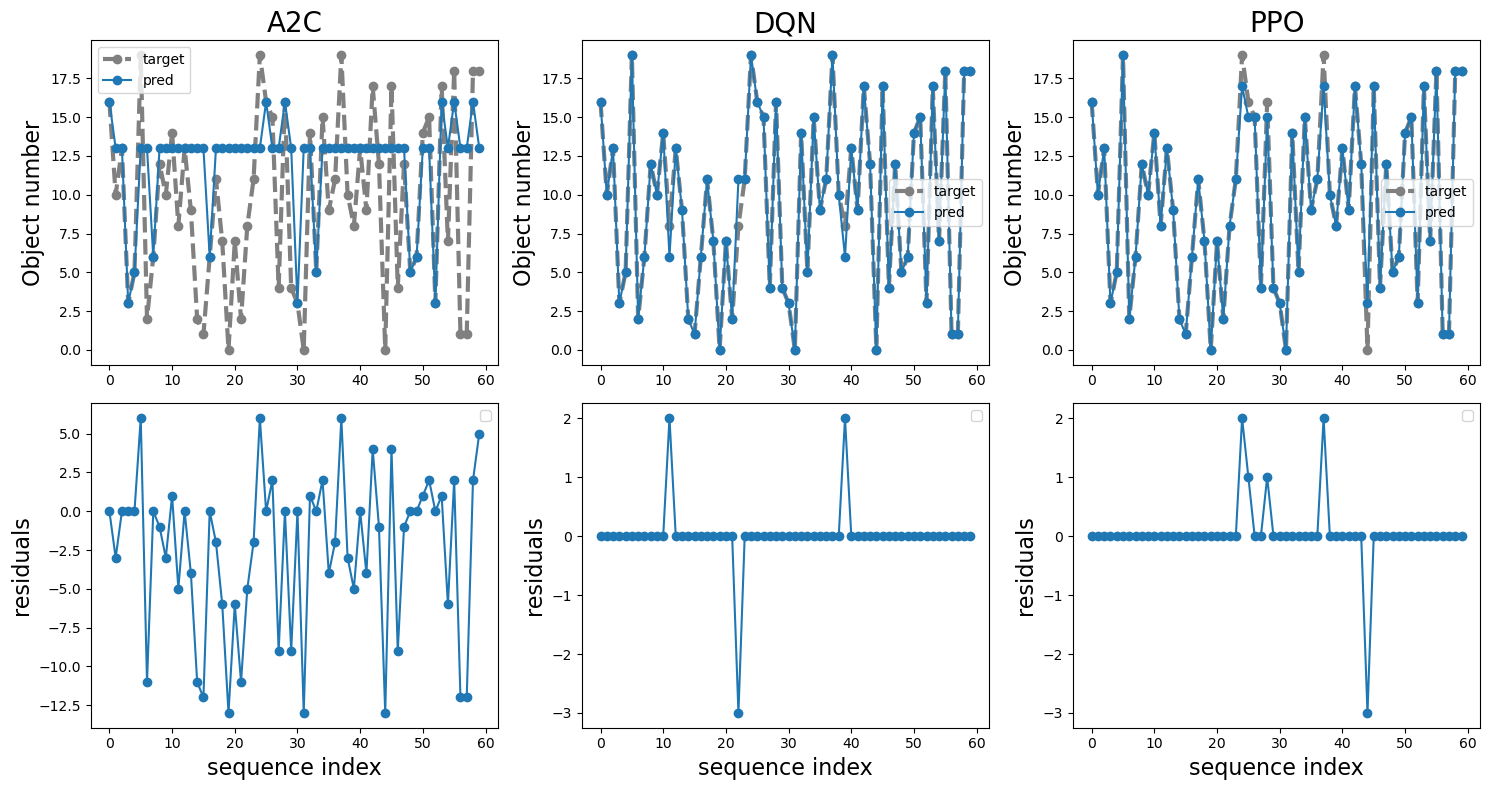

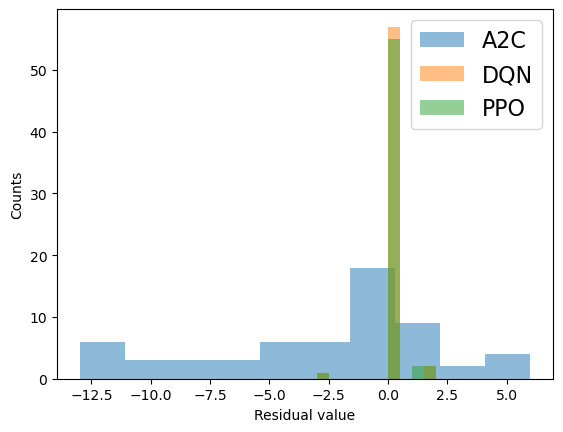

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()
    
# fig.savefig(OUTDIR + '')

In [20]:
n_episodes = 50
rewards = np.empty(shape=(len(true_sequence), n_episodes))
for i, model_name in enumerate(results.keys()):
    mean, std = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, deterministic=False)
    rewards[i], epsiodes = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, return_episode_rewards=True, deterministic=False)
    print(model_name, "mean =", f"{mean:.2f}", ', std = ', f"{std:.2f}")

A2C mean = 15.78 , std =  0.14
DQN mean = 53.43 , std =  1.41
PPO mean = 48.78 , std =  2.30


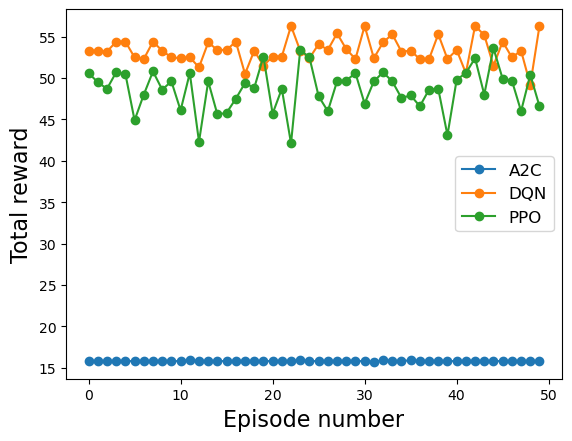

In [21]:
for i, model_name in enumerate(results.keys()):
    plt.plot(rewards[i], label=model_name, marker='o')
plt.xlabel('Episode number', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.legend(fontsize=12)

# Tune hyperparameters

In [23]:
def A2C_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 2e-4, 2e-3) # lr = 7e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999) # gamma=.99
    # entropy_coef = trial.suggest_loguniform('entropy_coef', 1e-5, 0.1)
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = A2C(policy="MultiInputPolicy", env=Monitor(env), learning_rate=learning_rate, gamma=gamma, verbose=0)
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

def PPO_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-3) # lr = 3e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999)
    # clip_range = trial.suggest_uniform('clip_range', 0.1, 0.3)
    # n_epochs = trial.suggest_int('n_epochs', 3, 20)
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = PPO(policy="MultiInputPolicy", env=Monitor(env), learning_rate=learning_rate, gamma=gamma, verbose=0)
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

def DQN_objective(trial):
    # hyperparam bounds
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-5, 5e-4) # 1e-4
    gamma = trial.suggest_uniform('gamma', 0.95, 0.9999)
    # buffer_size = trial.suggest_int('buffer_size', 50_000, 1_000_000, step=50_000)
    # batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    # train_freq = trial.suggest_categorical('train_freq', [1,2,3,4])
    # target_update_interval = trial.suggest_categorical('target_update_interval', [500, 1000, 5000, 10_000, 15_000])
    
    # Define env
    env = gym.make(f"gymnasium_env/{env_name}", Nf=Nf, target_sequence=true_sequence, nv_max=nv_max, off_by_lim=3)

    # Create the model with suggested hyperparameters
    model = DQN(
        policy="MultiInputPolicy",
        env=Monitor(env), 
        learning_rate=learning_rate, 
        gamma=gamma, 
        # buffer_size=buffer_size, 
        # batch_size=batch_size, 
        # train_freq=train_freq 
        verbose=0,
        # target_update_interval=target_update_interval
        )
    
    # Train the model
    model.learn(total_timesteps=10_000)
    
    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, Monitor(env), deterministic=False, n_eval_episodes=10)
    
    return mean_reward

In [31]:
[study.best_trial for study in [study_A2C, study_DQN, study_PPO]]

[FrozenTrial(number=58, state=1, values=[12.27], datetime_start=datetime.datetime(2025, 11, 5, 21, 8, 32, 972674), datetime_complete=datetime.datetime(2025, 11, 5, 21, 8, 40, 644375), params={'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.002, log=True, low=0.0002, step=None), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.95, step=None)}, trial_id=58, value=None),
 FrozenTrial(number=12, state=1, values=[49.129999999999995], datetime_start=datetime.datetime(2025, 11, 5, 21, 12, 13, 639286), datetime_complete=datetime.datetime(2025, 11, 5, 21, 12, 17, 764868), params={'learning_rate': 0.0004571391139950268, 'gamma': 0.9643604978484912}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0005, log=True, low=5e-05, step=None), 'gamma': FloatDistribution(high=0.9999, log=False, low=0.

In [32]:
[study.best_params for study in [study_A2C, study_DQN, study_PPO]]

[{'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508},
 {'learning_rate': 0.0004571391139950268, 'gamma': 0.9643604978484912},
 {'learning_rate': 0.0008293711733653031, 'gamma': 0.9770749910003036}]

In [33]:
results

{'A2C': {'model': <stable_baselines3.a2c.a2c.A2C at 0x7185c95c9390>,
  'train_time': 76.46415638923645},
 'DQN': {'model': <stable_baselines3.dqn.dqn.DQN at 0x7183b64ee310>,
  'train_time': 40.345316886901855},
 'PPO': {'model': <stable_baselines3.ppo.ppo.PPO at 0x7183b5680590>,
  'train_time': 62.17141604423523}}

In [34]:
studies = [study_A2C, study_DQN, study_PPO]

In [37]:
study_A2C.best_params

{'learning_rate': 0.0015555948713674756, 'gamma': 0.9660731517574508}

In [39]:
model_kwargs = {'policy': "MultiInputPolicy", "env": env, "verbose": True}
models = {'A2C': A2C, 'DQN':DQN, 'PPO':PPO}
results = {model_name: {'model': model(**model_kwargs, **studies[i].best_params)} for i, (model_name, model) in enumerate(models.items())}

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [43]:
for name in results.keys():
    file_path = OUTDIR + env_name + f'-Nf={Nf}-vmax={nv_max}_{name}'
    results[name]['model'].learn(total_timesteps=100_000, log_interval=10)
    results[name]['model'].save(path=file_path)

------------------------------------
| time/                 |          |
|    fps                | 857      |
|    iterations         | 10       |
|    time_elapsed       | 0        |
|    total_timesteps    | 50       |
| train/                |          |
|    entropy_loss       | -2.46    |
|    explained_variance | 0.399    |
|    learning_rate      | 0.00156  |
|    n_updates          | 9        |
|    policy_loss        | -0.0648  |
|    value_loss         | 0.00404  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 59       |
|    ep_rew_mean        | 1.6      |
| time/                 |          |
|    fps                | 926      |
|    iterations         | 20       |
|    time_elapsed       | 0        |
|    total_timesteps    | 100      |
| train/                |          |
|    entropy_loss       | -1.55    |
|    explained_variance | -0.476   |
|    learning_rate      | 0.00156  |
|

In [44]:
observation_list = np.empty(shape=(3, len(true_sequence)), dtype=dict)
reward_list = np.empty_like(observation_list)
terminated_list = np.empty_like(observation_list)
truncated_list = np.empty_like(observation_list)
info_list = np.empty_like(observation_list, dtype=dict)

In [45]:
for j, (name, model_dict) in enumerate(results.items()):
    obs, info = env.reset(seed=SEED)
    observation_list[j, 0] = obs
    info_list[j, 0] = info
    for i in range(len(true_sequence)):
        action, _states = results[name]['model'].predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action.tolist())
        observation_list[j,i+1] = obs
        info_list[j, i+1] = info
        reward_list[j, i] = reward
        terminated_list[j, i] = terminated
        truncated_list[j, i] = truncated
        if terminated or truncated:
            print(i)
            break

58
58
58


In [46]:
proposed_survey = np.empty_like(observation_list)
for j, obs_list in enumerate(observation_list):
    proposed_survey[j] = [observation_list[j, i]['field_id'] for i in range(len(observation_list[j]))]


In [47]:
print(proposed_survey)

[[16 12 12 3 2 19 2 6 12 12 12 6 2 9 2 2 6 12 6 2 6 2 6 12 19 16 12 4 16
  4 3 2 12 5 16 9 12 19 12 6 13 9 19 12 3 13 4 12 5 6 2 13 3 13 6 18 3 3
  18 18]
 [16 10 13 3 5 16 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 19 16 15 4 16
  4 3 0 14 5 15 9 11 19 10 8 13 9 17 12 0 17 4 12 5 6 14 15 3 17 7 18 1 1
  18 18]
 [16 10 13 18 2 19 2 6 12 10 14 8 13 9 2 1 6 11 7 0 7 2 8 11 19 16 15 4
  16 4 3 0 14 5 15 9 11 19 10 8 13 9 17 12 18 17 4 12 5 6 14 15 3 17 7 18
  1 17 18 18]]


In [48]:
print(true_sequence)

[16, 10, 13, 3, 5, 19, 2, 6, 12, 10, 14, 8, 13, 9, 2, 1, 6, 11, 7, 0, 7, 2, 8, 11, 19, 16, 15, 4, 16, 4, 3, 0, 14, 5, 15, 9, 11, 19, 10, 8, 13, 9, 17, 12, 0, 17, 4, 12, 5, 6, 14, 15, 3, 17, 7, 18, 1, 1, 18, 18]


/tmp/ipykernel_67607/289756295.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,i].legend()


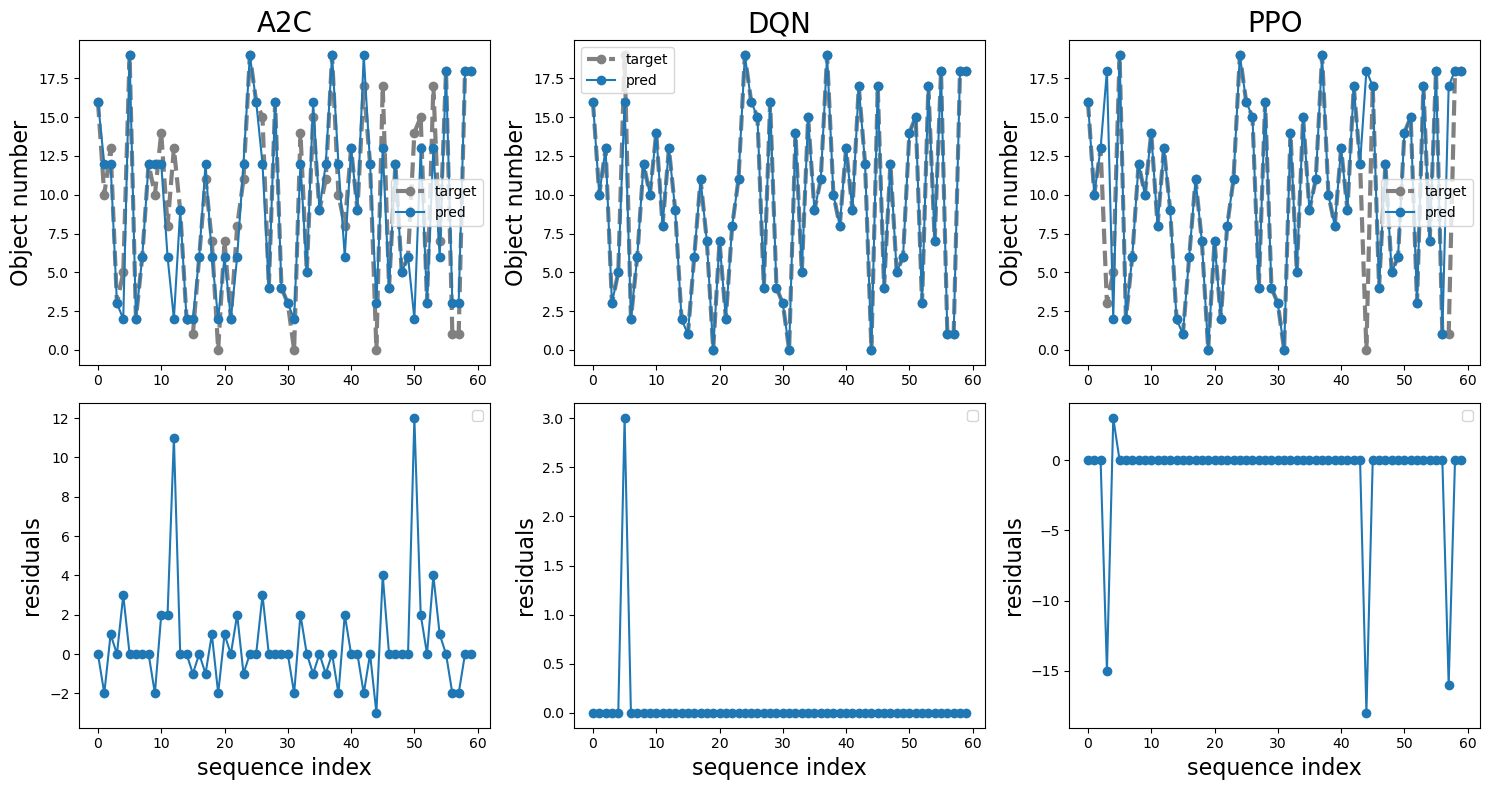

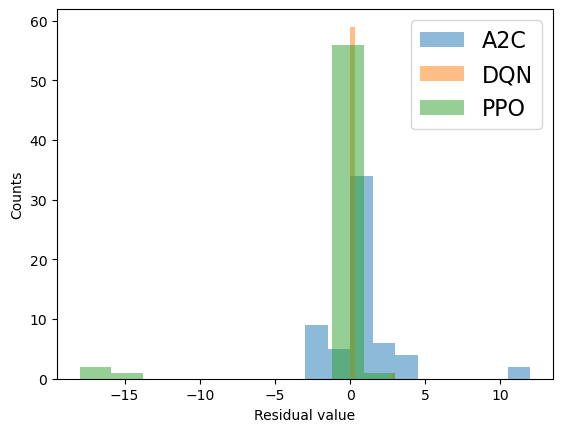

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()
    
# fig.savefig(OUTDIR + '')

In [50]:
n_episodes = 50
rewards = np.empty(shape=(len(true_sequence), n_episodes))
for i, model_name in enumerate(results.keys()):
    mean, std = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, deterministic=False)
    rewards[i], epsiodes = evaluate_policy(results[model_name]['model'], Monitor(env), n_eval_episodes=n_episodes, return_episode_rewards=True, deterministic=False)
    print(model_name, "mean =", f"{mean:.2f}", ', std = ', f"{std:.2f}")

A2C mean = 31.07 , std =  0.86
DQN mean = 55.04 , std =  1.39
PPO mean = 50.85 , std =  3.19


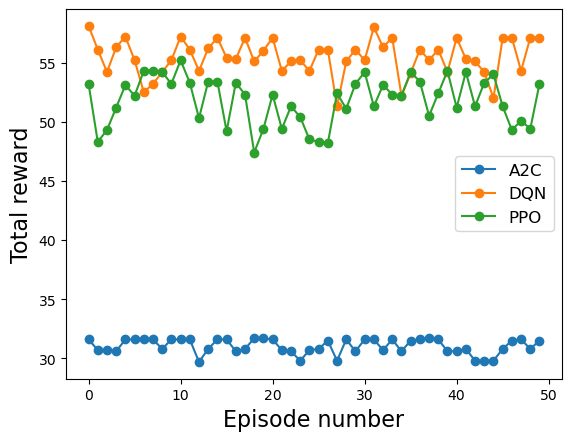

In [51]:
for i, model_name in enumerate(results.keys()):
    plt.plot(rewards[i], label=model_name, marker='o')
plt.xlabel('Episode number', fontsize=16)
plt.ylabel('Total reward', fontsize=16)
plt.legend(fontsize=12)